In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# Define dates: last 10 years
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)  # roughly 10 years

# Download historical stock data
df = yf.download('TSLA', start=start_date, end=end_date)

# Preview the data
print(df.head())
print(df.tail())

C:\Users\Amarjeet\AppData\Local\Temp\ipykernel_23672\4000699181.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TSLA', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2015-11-23  14.516667  14.612000  14.312000  14.490000  37893000
2015-11-24  14.550000  14.733333  14.333333  14.358000  37204500
2015-11-25  15.309333  15.388667  14.692000  14.756000  59862000
2015-11-27  15.440667  15.483333  15.134000  15.404000  29241000
2015-11-30  15.350667  15.618667  15.272000  15.452667  39897000
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-11-11  439.619995  442.489990  432.359985  439.399994   60533200
2025-11-12  430.600006  442.329987  426.559998  442.149994   58513500
2025-11-13  401.989990  424.500000  396.339996  423.130005  118948000
2025-11-14  404.350006  412.190002  382.779999  386.299988  

In [3]:
df1 = df.reset_index()['Close']

In [4]:
df1.shape

(2511, 1)

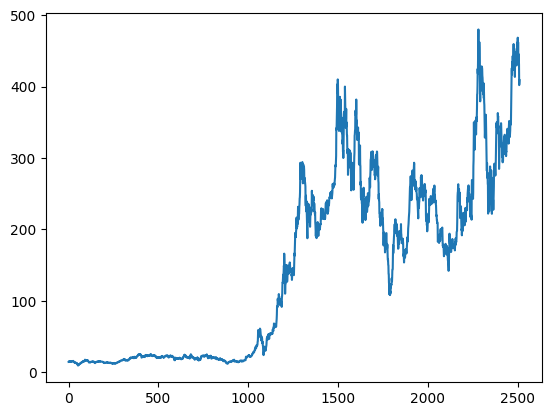

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
# LSTM are sensitive to sacle of the data. Hence we apply MinMax Scaler

In [7]:
import numpy as np

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
df1.shape

(2511, 1)

In [10]:
# Splitting dataset into train data and test split

training_size = int(len(df1)*0.7)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size, test_size

(1757, 754)

In [13]:
def create_dataset(dataset, timestep = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - timestep-1):
        a = dataset[i:(i+timestep),0]           
        dataX.append(a)
        dataY.append(dataset[i+timestep, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
# Reshape into X=t, t+1, t+2, t=3 and Y=t+4
timestep = 100
X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

In [15]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(1656, 100)
(1656,)
(653, 100)
(653,)


(None, None)

In [16]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
# Create Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input

In [18]:
# model = Sequential()
# model.add(LSTM(50, return_sequences = True, input_shape=(100,1)))
# model.add(LSTM(50, return_sequences = True))
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

model = Sequential([
    Input(shape=(100, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
26/26 [==============================] - 9s 191ms/step - loss: 0.0188 - val_loss: 0.0064
Epoch 2/100
26/26 [==============================] - 4s 144ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 3/100
26/26 [==============================] - 4s 138ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 4/100
26/26 [==============================] - 3s 130ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 5/100
26/26 [==============================] - 4s 141ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 6/100
26/26 [==============================] - 4s 141ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 7/100
26/26 [==============================] - 3s 132ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 8/100
26/26 [==============================] - 4s 137ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 9/100
26/26 [==============================] - 4s 144ms/step - loss: 9.4774e-04 - val_loss: 0.0035
Epoch 10/100
26/26 [==============================] - 4s 140ms/step - loss: 0.0011 - va

In [21]:
import tensorflow as tf

In [22]:
# Lets do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

21/21 [==============================] - 1s 27ms/step


In [23]:
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

152.74596897459935

In [25]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

280.1587855005244

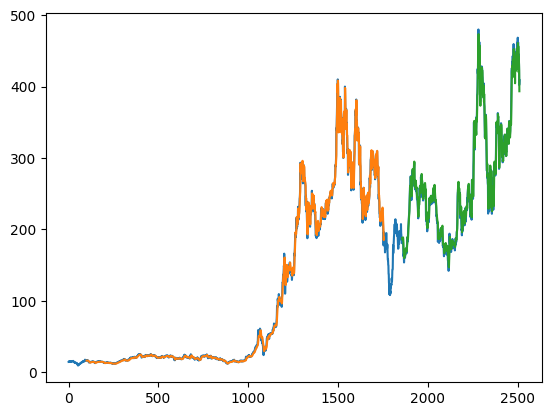

In [26]:
# Shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
len(test_data)

754

In [29]:
# Taking last 100 days data
x_input = test_data[654:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [31]:
from numpy import array

lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

# Predicting next 30 days stock price
while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1 
print(lst_output)

[0.84269834]
101
1 day input [0.65510058 0.61905835 0.65082653 0.65018864 0.60466276 0.61289185
 0.60878795 0.63853604 0.6462761  0.65348451 0.64047105 0.6636274
 0.65882176 0.68059591 0.67812929 0.68582679 0.68678369 0.62881845
 0.65169836 0.67196279 0.662628   0.658035   0.63513381 0.62314104
 0.63723897 0.63609071 0.65988495 0.66490318 0.68059591 0.7005414
 0.70439015 0.70128564 0.69320535 0.68253092 0.6923123  0.67987294
 0.6683692  0.66031019 0.70262528 0.71663814 0.72741892 0.72301729
 0.71531979 0.68956925 0.67997924 0.69003706 0.6994782  0.72565398
 0.71621283 0.71742489 0.71916854 0.7638651  0.82155391 0.85153593
 0.87615943 0.88517527 0.8660166  0.88562186 0.90293059 0.88515405
 0.921175   0.87992317 0.91609291 0.92206805 0.92527891 0.95662178
 0.90673684 0.89361702 0.94341696 0.90054905 0.91245681 0.90575872
 0.85887192 0.90652419 0.89236246 0.9049294  0.89132055 0.91377516
 0.93104139 0.92077098 0.9130522  0.93433732 0.90188868 0.94165209
 0.95893953 0.96098091 0.91545502 0

In [32]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [33]:
len(df1)

2511

In [34]:
df3 = df1.tolist()
df3.extend(lst_output)

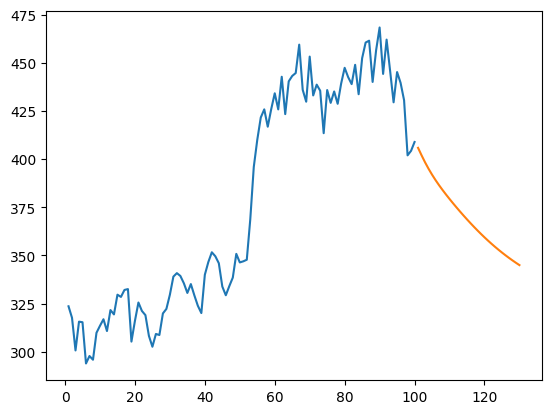

In [35]:
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1[2411:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

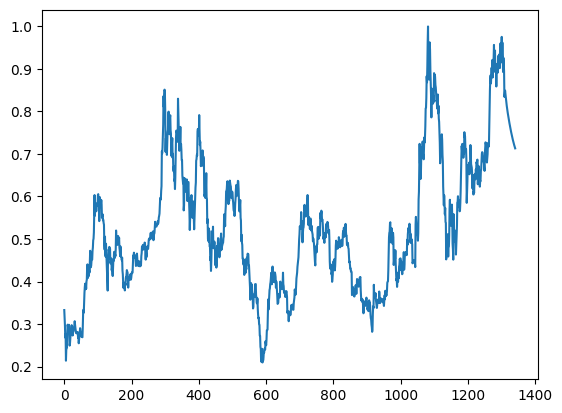

In [37]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])